In [1]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.service import Service
import pandas as pd
import time
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import re
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import itertools
from collections import Counter
from nltk.stem import SnowballStemmer
st = SnowballStemmer('english')

In [2]:
service = Service()
options = webdriver.ChromeOptions()
#
main_link = 'https://www.airlinequality.com/airline-reviews/british-airways/page/1/?sortby=post_date%3ADesc&pagesize=100'

In [3]:
#Loading
driver = webdriver.Chrome(service=service, options=options)
driver.get(main_link)
time.sleep(4)

#Cookies
driver.find_element(By.CSS_SELECTOR, 'button.fc-button.fc-cta-consent.fc-primary-button').click() #Akceptowanie cookies
time.sleep(1)

In [4]:
#scraping
a = []
b = []

#loop
for x in range(1, 6):
    main_link = 'https://www.airlinequality.com/airline-reviews/british-airways/page/' + str(x) + '/?sortby=post_date%3ADesc&pagesize=100'
    driver.get(main_link)
    time.sleep(2)
    a = a + (list(map(lambda i: i.text, driver.find_elements(By.CSS_SELECTOR, 'div.text_content'))))
    b = b + (list(map(lambda i: i.text, (driver.find_elements(By.CSS_SELECTOR, 'table.review-ratings')[1:]))))
    time.sleep(2)

driver.quit()

In [5]:
#Reviews
verified = list(map(lambda i: 0 if i.split("|")[0].__contains__("Not") else 1, a))
text = list(map(lambda i: i.split("|")[1].strip(), a))

#Tabelki
type_traveller = list(map(lambda i: [s for s in i.split("\n") if "Type Of Traveller" in s][0][18:] if [s for s in i.split("\n") if "Type Of Traveller" in s] != [] else pd.NA, b))
seat_type = list(map(lambda i: [s for s in i.split("\n") if "Seat Type" in s][0][10:], b))
recommended = list(map(lambda i: 0 if i.split("\n")[-1].__contains__("no") else 1, b))

#Gwiazdki
# seat_comfort = driver.find_elements(By.CSS_SELECTOR, '')
# seat_comfort = list(map(lambda i: i.text, seat_comfort))

#into df
dict = {'verified':verified, 'text':text, 'type_traveller':type_traveller, 'seat_type':seat_type, 'recommended':recommended}
df = pd.DataFrame(dict)
# display(df)

In [6]:
#only verified
df = df[df['verified'] == 1]
df.drop(columns=['verified'], inplace=True)
df = df.reset_index(drop=True)

In [7]:
display(df.groupby('type_traveller').count()['text'])

display(df.groupby('seat_type').count()['text'])

type_traveller
Business           68
Couple Leisure    108
Family Leisure     61
Solo Leisure      132
Name: text, dtype: int64

seat_type
Business Class     129
Economy Class      202
First Class         10
Premium Economy     29
Name: text, dtype: int64

In [8]:
#Cleaning
df['text']=df['text'].apply(lambda x: word_tokenize(x))
df['text']=df['text'].apply(lambda row: [i.lower() for i in row])
df['text']=df['text'].apply(lambda row: [i for i in row if i not in stopwords.words('english') and i not in "'s"])
df['text']=df['text'].apply(lambda row: [i for i in row if re.search('\w', i)])
df['text']=df['text'].apply(lambda row: [i for i in row if i not in ['ba', 'u', "n't"]])
display(df)

#Stemming
dfstem = df.copy()
dfstem['text'] = dfstem['text'].apply(lambda row: [st.stem(i) for i in row ])

text  type_traveller  \
0    [flew, amsterdam, las, vegas, layover, heathro...        Business   
1    [first, good, news, club, suites, huge, improv...  Couple Leisure   
2    [never, travelled, british, airways, first, ti...    Solo Leisure   
3    [terrible, overall, medium, service, flight, d...  Couple Leisure   
4    [london, heathrow, male, new, business, class,...  Couple Leisure   
..                                                 ...             ...   
365  [british, airways, late, website, atrocious, w...    Solo Leisure   
366  [flew, amman, london, nov., 14, 2022, sure, ty...    Solo Leisure   
367  [worst, experience, ever, airline, flew, briti...    Solo Leisure   
368  [flying, lhr, t5, cpt, november, 2022, app, we...    Solo Leisure   
369  [check, shambles, bwi, 3, counters, open, full...    Solo Leisure   

           seat_type  recommended  
0    Premium Economy            0  
1     Business Class            0  
2      Economy Class            1  
3      Economy Class            0  
4     Business Class            1  
..               ...          ...  
365    Economy Class            0  
366  Premium Economy            0  
367    Economy Class            0  
368   Business Class            0  
369    Economy Class            1  

[370 rows x 4 columns]

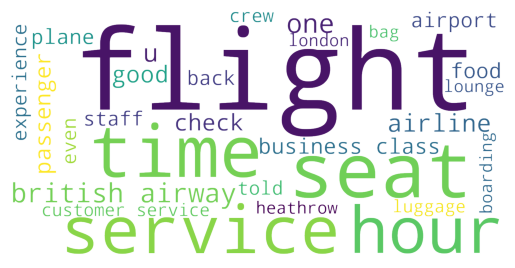

In [9]:
#Wordcloud
text = ' '.join(df['text'].apply(lambda x: ' '.join(x)))
wordcloud = WordCloud(width = 1600, height = 800, max_words = 29, background_color="rgba(255, 255, 255, 0)", mode="RGBA", min_font_size = 10).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()
# plt.savefig('output.png', transparent=True)

In [10]:
# Filter rows where recommended == 0
df_negative = dfstem[dfstem['recommended'] == 0]
#
print("service " + str(df_negative['text'].apply(lambda x: 'servic' in x).sum()/len(df_negative)))
print("delay " + str(df_negative['text'].apply(lambda x: 'delay' in x).sum()/len(df_negative)))
print("food " + str(df_negative['text'].apply(lambda x: 'food' in x).sum()/len(df_negative)))
print("luggag " + str(df_negative['text'].apply(lambda x: 'luggag' in x).sum()/len(df_negative)))

service 0.5261194029850746
delay 0.31343283582089554
food 0.26119402985074625
luggag 0.20522388059701493


In [11]:
# Filter rows where recommended == 1
df_positive = dfstem[dfstem['recommended'] == 1]
#
print("service " + str(df_positive['text'].apply(lambda x: 'servic' in x).sum()/len(df_positive)))
print("delay " + str(df_positive['text'].apply(lambda x: 'delay' in x).sum()/len(df_positive)))
print("food " + str(df_positive['text'].apply(lambda x: 'food' in x).sum()/len(df_positive)))
print("luggag " + str(df_positive['text'].apply(lambda x: 'luggag' in x).sum()/len(df_positive)))

service 0.5686274509803921
delay 0.22549019607843138
food 0.47058823529411764
luggag 0.14705882352941177


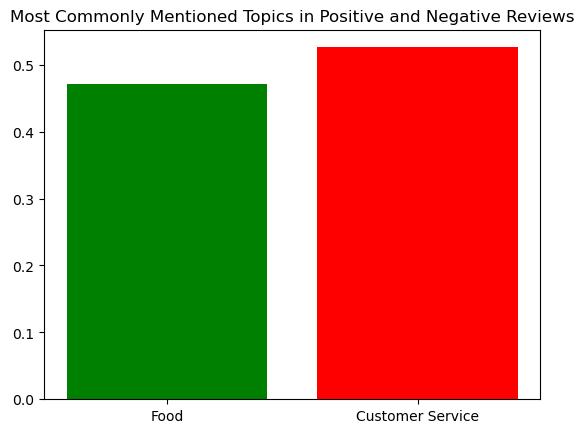

In [34]:
# Values
positive_food_ratio = df_positive['text'].apply(lambda x: 'food' in x).sum() / len(df_positive)
negative_service_ratio = df_negative['text'].apply(lambda x: 'servic' in x).sum() / len(df_negative)

# Bar chart
plt.bar(['Food', 'Customer Service'], [positive_food_ratio, negative_service_ratio], color=['green', 'red'])
plt.title('Most Commonly Mentioned Topics in Positive and Negative Reviews')
plt.savefig('output.png', transparent=True)
# plt.show()

In [17]:
len(df_negative) / (len(df_negative) + len(df_positive))

0.7243243243243244

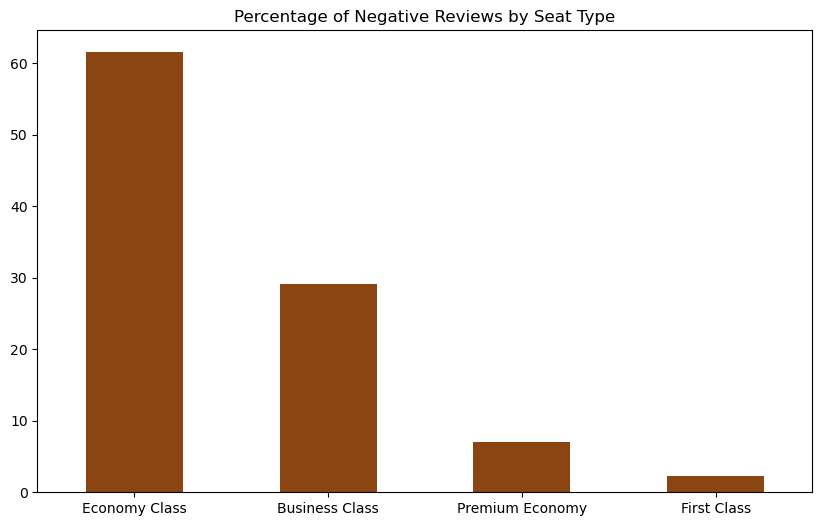

In [32]:
# values
negative_reviews_by_traveller = df_negative['seat_type'].value_counts(normalize=True) * 100

# bar plot
negative_reviews_by_traveller.plot(kind='bar', color='saddlebrown')
plt.title('Percentage of Negative Reviews by Seat Type')
plt.xlabel('')
plt.gcf().set_size_inches(10, 6)
plt.xticks(rotation=0)
plt.savefig('output.png', transparent=True)
plt.show()